In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2011completefinaldatasets.csv')

data.shape

(720, 8)

# Exploratory Data Analysis

In [4]:
# Convert "Time" to datetime and set as index
data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-w%W-%w')

data.head(), data.tail()

(        Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 0 2011-01-03  9.938571       29.444400           25.888890       23.888900   
 1 2011-01-10  8.587143       30.000000           26.705556       24.444444   
 2 2011-01-17  5.338571       30.000000           26.616667       25.000000   
 3 2011-01-24  5.410000       30.555556           26.483333       20.555556   
 4 2011-01-31  2.914286       28.333333           25.283333       18.650000   
 
     Wind   Humidity  Cases  
 0  11.39  86.242857      5  
 1   7.32  88.028571      4  
 2   7.55  84.028571      2  
 3  10.67  80.971429      7  
 4  11.01  74.885714      2  ,
           Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 715 2024-09-30     1.016       33.333333           28.866667       25.555556   
 716 2024-10-07     9.652       32.777778           28.561111       25.000000   
 717 2024-10-14    25.400       33.333333           29.083333       25.000000   
 718 2024-10-21    

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                720 non-null    datetime64[ns]
 1   Rainfall            720 non-null    float64       
 2   MaxTemperature      720 non-null    float64       
 3   AverageTemperature  720 non-null    float64       
 4   MinTemperature      720 non-null    float64       
 5   Wind                720 non-null    float64       
 6   Humidity            720 non-null    float64       
 7   Cases               720 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 45.1 KB


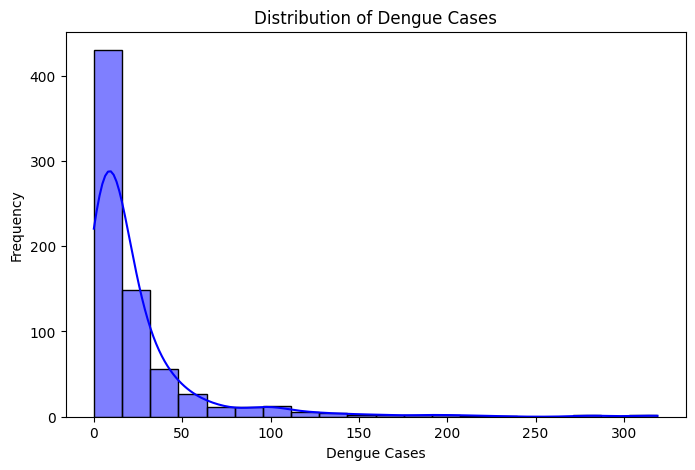

,Time,Rainfall,MaxTemperature,AverageTemperature,MinTemperature,Wind,Humidity,Cases
count,720,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2017-12-02 11:22:00,13.957499,32.191142,28.110319,25.038472,6.172417,81.609442,23.744444
min,2011-01-03 00:00:00,0.000000,-14.600000,24.494444,12.222222,1.910000,73.185714,0.000000
25%,2014-06-21 06:00:00,1.270000,31.666667,27.504167,25.000000,4.117500,79.885713,5.000000
50%,2017-12-07 12:00:00,4.318000,32.222222,28.161111,25.000000,5.725000,81.771429,12.000000
75%,2021-05-11 18:00:00,10.414000,32.777778,28.751389,25.555556,7.860000,83.503571,26.000000
max,2024-10-28 00:00:00,445.008000,58.333333,30.916667,32.222222,19.200000,89.571429,319.000000
std,NaN,35.448846,2.616379,0.999800,1.291659,2.446703,2.831674,37.144813


In [6]:
# Summary statistics
summary_stats = data.describe()

# Distribution of dengue cases
plt.figure(figsize=(8, 5))
sns.histplot(data["Cases"], bins=20, kde=True, color="blue")
plt.xlabel("Dengue Cases")
plt.ylabel("Frequency")
plt.title("Distribution of Dengue Cases")
plt.show()

# Display summary statistics
summary_stats

In [7]:
# # Categorizing dengue cases into intervals
# bins = [0, 5, 15, 30, 100, 320]  # Case intervals
# labels = ["0-5", "6-15", "16-30", "31-100", "101+"]  # Interval labels
# data["Cases_Interval"] = pd.cut(data["Cases"], bins=bins, labels=labels, right=False)

# # Count plot for different case intervals
# plt.figure(figsize=(8, 5))
# sns.countplot(x="Cases_Interval", data=data, palette="coolwarm", order=labels)
# plt.xlabel("Dengue Case Intervals")
# plt.ylabel("Frequency")
# plt.title("Frequency of Dengue Cases in Different Intervals")
# plt.show()

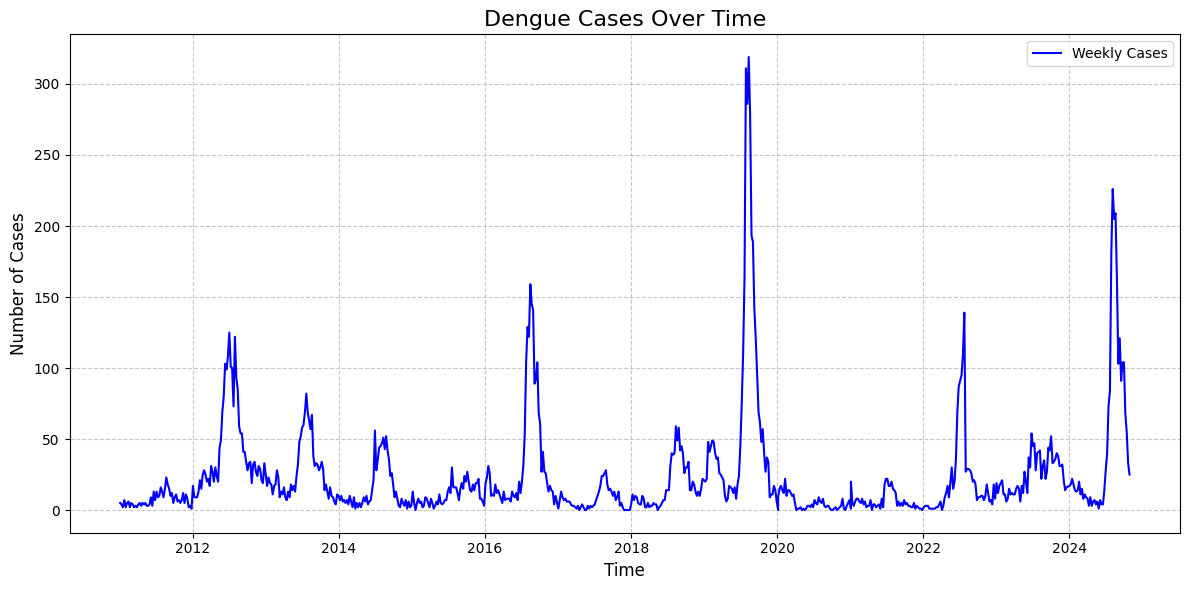

In [8]:
# Analyze the cases over time to observe seasonality
plt.figure(figsize=(12, 6))
plt.plot(data['Time'][:len(data)], data['Cases'], color='blue', label='Weekly Cases')
plt.title('Dengue Cases Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Compute correlation between weather factors and cases
correlation_matrix = data.corr()
case_correlation = correlation_matrix['Cases'].sort_values(ascending=False)

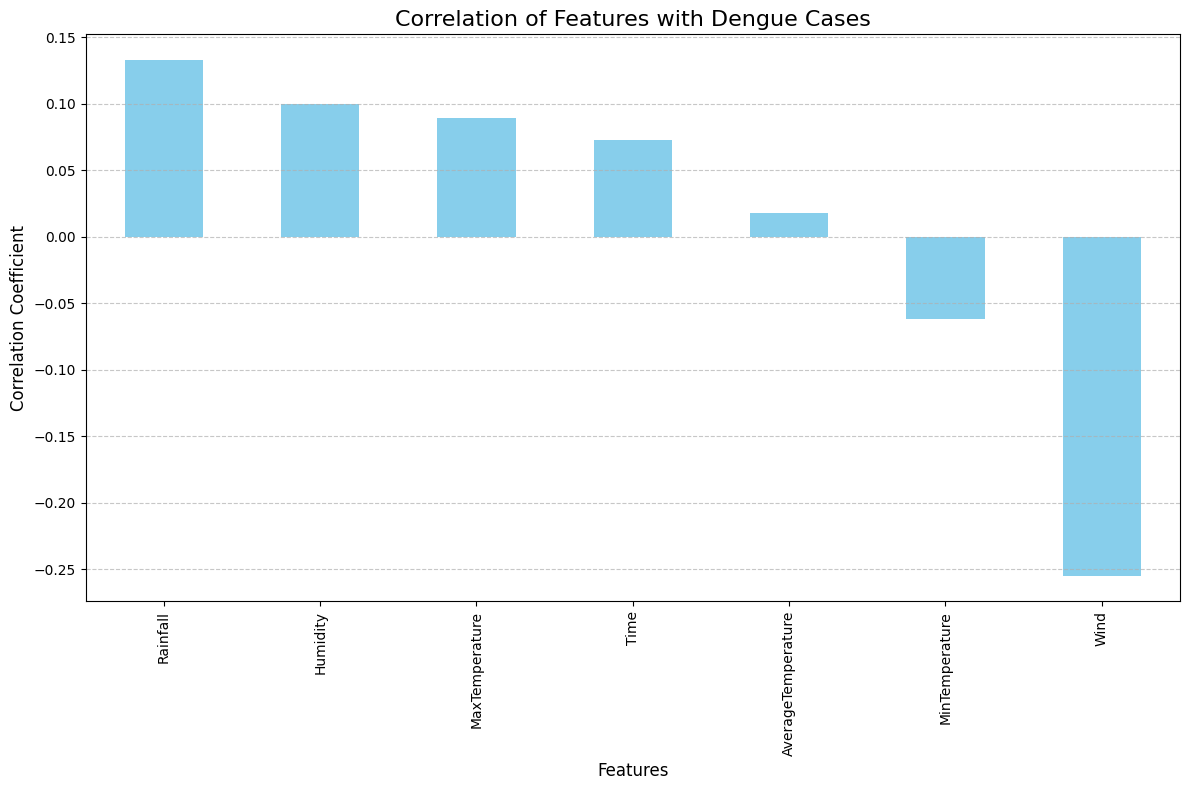

In [10]:
# Plot correlation of all features with Cases
plt.figure(figsize=(12, 8))
case_correlation.drop('Cases').plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Dengue Cases', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Identify top 3 correlated weather factors with cases
top_3_factors = case_correlation.index[1:4]

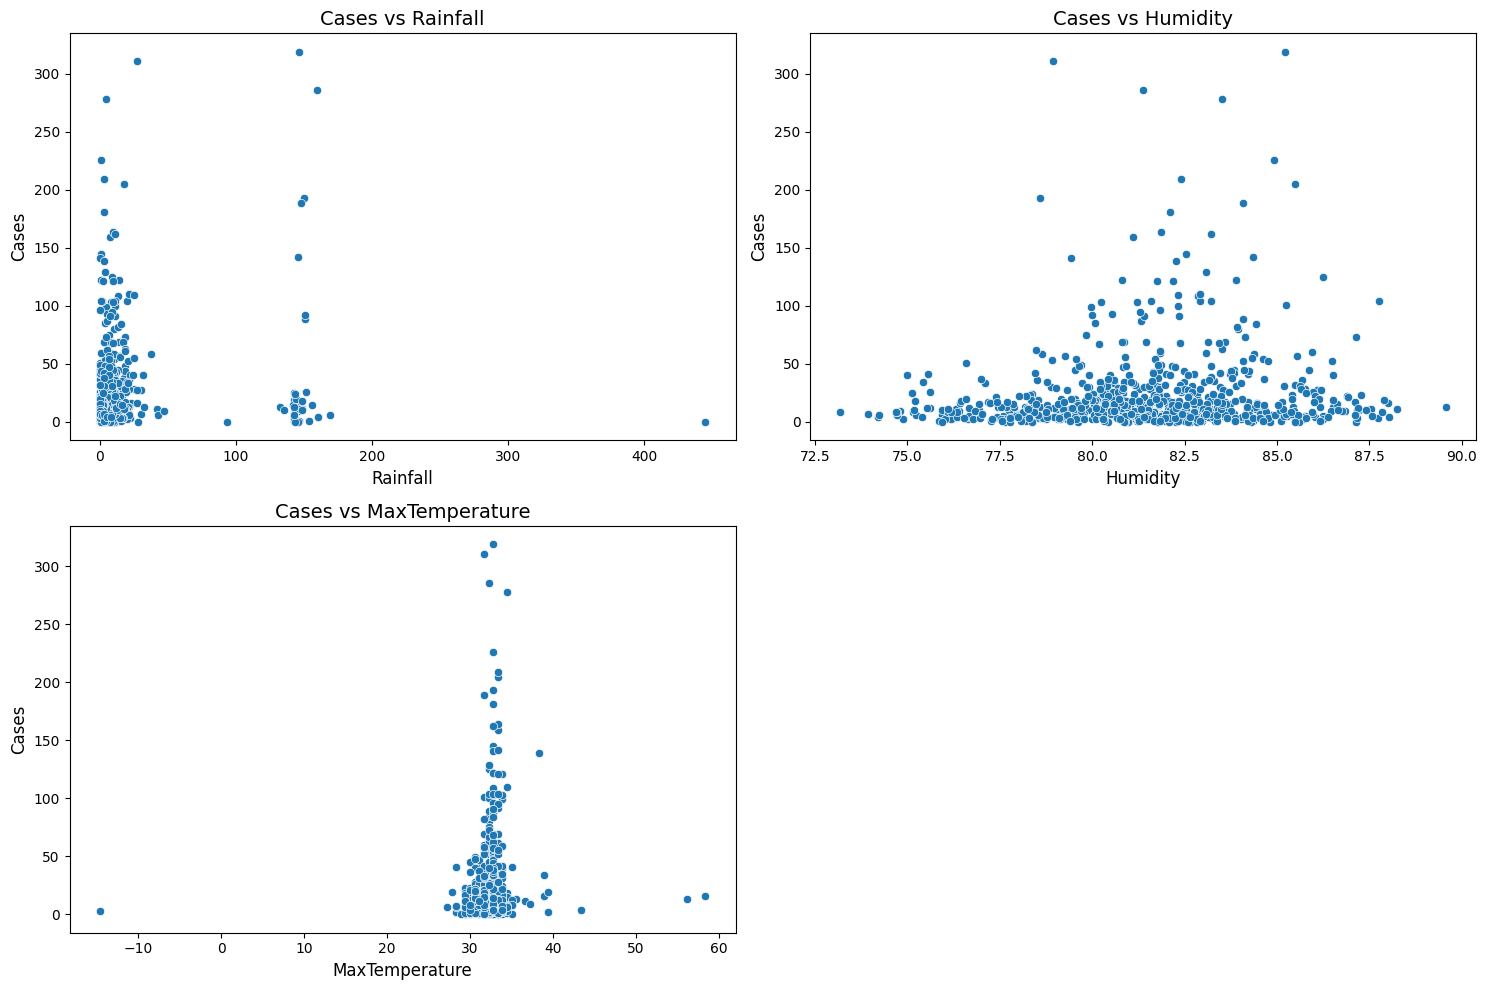

In [12]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(top_3_factors, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=data[factor], y=data['Cases'], edgecolor='w')
    plt.title(f'Cases vs {factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
    plt.ylabel('Cases', fontsize=12)
plt.tight_layout()
plt.show()

#Outbreak Computation

In [13]:
# Get the last four datapoints (1 month)
last_four_rows = data.tail(4)

# Create a new DataFrame containing the last four rows
last_four_df = data.tail(4)

# Summary statistics for the entire dataset
month_summary_stats = last_four_df.describe()

# Display the summary statistics
print(month_summary_stats)

                      Time   Rainfall  MaxTemperature  AverageTemperature  \
count                    4   4.000000        4.000000            4.000000   
mean   2024-10-17 12:00:00  14.541500       32.500000           28.348611   
min    2024-10-07 00:00:00   2.540000       31.666667           27.455556   
25%    2024-10-12 06:00:00   7.874000       32.083333           28.084722   
50%    2024-10-17 12:00:00  15.113000       32.500000           28.427778   
75%    2024-10-22 18:00:00  21.780500       32.916667           28.691667   
max    2024-10-28 00:00:00  25.400000       33.333333           29.083333   
std                    NaN  10.364061        0.717219            0.679572   

       MinTemperature      Wind   Humidity      Cases  
count        4.000000  4.000000   4.000000   4.000000  
mean        24.861111  5.265000  84.128571  45.250000  
min         23.888889  4.260000  82.385714  25.000000  
25%         24.722222  4.597500  83.607143  31.000000  
50%         25.000000  4.8

#Training

In [14]:
# Select features for normalization (excluding the target column)
features = data[['Rainfall', 'MaxTemperature','Humidity']]
target = data['Cases']

features.shape, target.shape

((720, 3), (720,))

In [15]:
# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Convert back to DataFrame for better manipulation
normalized_data = pd.DataFrame(normalized_features, columns=features.columns, index=data.index)
normalized_data['Cases'] = normalized_target

In [16]:
normalized_data.head()

,Rainfall,MaxTemperature,Humidity,Cases
0,0.022333,0.603899,0.796861,0.015674
1,0.019297,0.611517,0.905841,0.012539
2,0.011997,0.611517,0.661726,0.006270
3,0.012157,0.619135,0.475153,0.021944
4,0.006549,0.588665,0.103749,0.006270


In [17]:
# Function to create sequences for LSTM
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [18]:
# Initialize variables for results
window_sizes = [5, 10,20]
val_losses = []
histories = []
results = {}

In [19]:
# Loop over different window sizes
for window_size in window_sizes:
    # Prepare the sequences using the current window size
    X, y = create_sequences(normalized_data.values, normalized_target, window_size)

    # Split into training and testing sets (80% training, 20% testing)
    split_index = int(len(X) * 0.80)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Define the LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))  # Output layer to predict dengue cases

    # Compile the model with Adam optimizer and custom learning rate
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=1,
                        validation_data=(X_test, y_test), verbose=1,
                        callbacks=[early_stopping])
    val_loss = model.evaluate(X_test, y_test, verbose=0)

    val_losses.append(val_loss)
    histories.append(history)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Rescale back to original dengue case values
    predicted_actual_scale = scaler_target.inverse_transform(y_pred)
    y_test_actual_scale = scaler_target.inverse_transform(y_test)

    # Compute MSE and RMSE
    mse = mean_squared_error(y_test_actual_scale, predicted_actual_scale)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual_scale, predicted_actual_scale)
    r2 = r2_score(y_test_actual_scale, predicted_actual_scale)

    # Store results
    results[window_size] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predicted': predicted_actual_scale.flatten(),
        'actual': y_test_actual_scale.flatten(),
        'history': history
    }

Epoch 1/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 2/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 3/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 4/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 5/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 7/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 9/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 10/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 11/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 12/100
572/572 ━━━━━━━━━━━━━━━━━━━━

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


# Evaluation Metrics

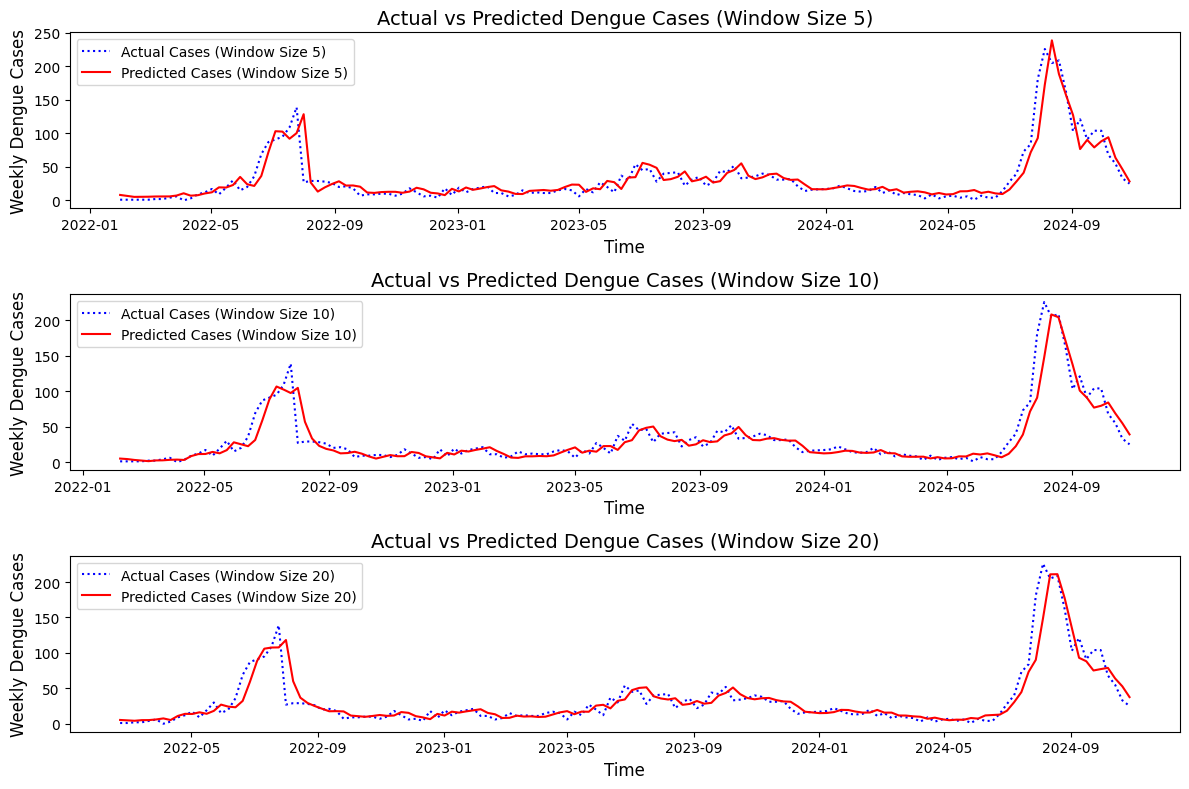

In [20]:
# Plot the performance for different window sizes in separate plots
plt.figure(figsize=(12, 8))
for i, (window_size, result) in enumerate(results.items(), 1):
    plt.subplot(len(results), 1, i)  # Create a subplot for each window size
    plt.plot(
        data['Time'][len(data) - len(result['actual']):],
        result['actual'],
        label=f'Actual Cases (Window Size {window_size})',
        linestyle='dotted',
        color='blue'
    )
    plt.plot(
        data['Time'][len(data) - len(result['predicted']):],
        result['predicted'],
        label=f'Predicted Cases (Window Size {window_size})',
        color='red'
    )
    plt.title(f'Actual vs Predicted Dengue Cases (Window Size {window_size})', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Weekly Dengue Cases', fontsize=12)
    plt.legend()
    plt.tight_layout()

plt.show()


In [21]:
# Display MSE and RMSE for different window sizes
for window_size, result in results.items():
    print(f"Window Size {window_size} - MSE: {result['mse']:.2f}, RMSE: {result['rmse']:.2f}, MAE: {result['mae']:.2f}, R2: {result['r2']:.2f}")

Window Size 5 - MSE: 275.23, RMSE: 16.59, MAE: 9.79, R2: 0.84
Window Size 10 - MSE: 261.38, RMSE: 16.17, MAE: 9.18, R2: 0.85
Window Size 20 - MSE: 267.59, RMSE: 16.36, MAE: 8.80, R2: 0.84


### Choose the best window size

In [22]:
best_index = np.argmin(val_losses)
best_window_size = window_sizes[best_index]
print(f"Best window size: {best_window_size}")

Best window size: 10


# Hyperparameter Tuning

In [23]:
import keras_tuner as kt

In [24]:
X_final, y_final = create_sequences(normalized_data.values, normalized_target, best_window_size)

# Split into training and testing sets (80% training, 20% testing)
split_index = int(len(X) * 0.80)
X_train, X_test = X_final[:split_index], X_final[split_index:]
y_train, y_test = y_final[:split_index], y_final[split_index:]

### Define the Search Space (build_model)

In [25]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                   return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='LOG')),
        loss='mean_squared_error'
    )
    return model


### Set up the Bayesian Tuner

In [26]:
# Create tuner instance
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='dengue_lstm_tuning'
)

Reloading Tuner from kt_dir/dengue_lstm_tuning/tuner0.json


In [27]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

### Perform the search for best hyperparameters

In [28]:
tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=1)

### Get the best model and evaluate

In [29]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: Units = {best_hps.get('units')}, Learning rate = {best_hps.get('lr')}")

Best hyperparameters: Units = 256, Learning rate = 0.0012405181050498832


### Build and train the best model

In [30]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0094 - val_loss: 0.0023
Epoch 2/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0068 - val_loss: 4.8842e-04
Epoch 3/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 4/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0028 - val_loss: 2.9155e-04
Epoch 6/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0025 - val_loss: 4.3991e-04
Epoch 7/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027 - val_loss: 3.1188e-04
Epoch 8/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055 - val_loss: 9.0221e-04
Epoch 9/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016 - val_loss: 5.7380e-04


### Predict and evaluate

In [31]:
predictions = model.predict(X_test)

# Rescale back to original dengue case values
predicted_actual_scale = scaler_target.inverse_transform(predictions)
y_test_actual_scale = scaler_target.inverse_transform(y_test)

# Compute MSE and RMSE
mse = mean_squared_error(y_test_actual_scale, predicted_actual_scale)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual_scale, predicted_actual_scale)
r2 = r2_score(y_test_actual_scale, predicted_actual_scale)

print(f"Tuned Model MSE: {mse}")
print(f"Tuned Model RMSE: {rmse}")
print(f"Tuned Model MAE: {mae}")
print(f"Tuned Model R²: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Tuned Model MSE: 317.7042693255191
Tuned Model RMSE: 17.824260695061636
Tuned Model MAE: 10.428965930938721
Tuned Model R²: 0.8096829657587781
